In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm, sem
import scipy.stats as st
import random
import pulp
from datetime import datetime
from scipy import stats

In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# All-in-one

In [3]:
# set up the optimization problem
Trans = pulp.LpProblem("Transshipment_Problem", pulp.LpMinimize)

In [4]:
# the number of stores
store = [1, 2, 3, 4, 5, 6, 7]
n = len(store)

# the number of scenarios
scenario = list(range(1, 3**7 + 1))
ns = len(scenario)

In [5]:
# 3^7 scenarios
# stochastic parameter ---> demand of each store
mu = pulp.makeDict([store], [100, 200, 150, 170, 180, 170, 170], 0)
sigma = pulp.makeDict([store], [20, 50, 30, 50, 40, 30, 50], 0)

d0 = [stats.norm.ppf(q = [0.25, 0.5, 0.75], loc = mu[i], scale = sigma[i]).tolist() for i in range(1,8)]
d1 = list(itertools.product(d0[0], d0[1], d0[2], d0[3], d0[4], d0[5], d0[6]))
d = [list(i) for i in d1]
d = pulp.makeDict([scenario, store], d, 0)

In [6]:
# set up fixed parameters

# 7 stores replenishment cost
Cr = [0, 0, 0, 0, 0, 0, 0]
Cr = pulp.makeDict([store], Cr, 0)

# 7 stores holding inventory cost
h = [[1, 1, 1, 1, 1, 1, 1]] * ns
h = pulp.makeDict([scenario, store], h, 0)

# transshipment routes from i to j
routes = [(k, i, j) for k in scenario for i in store for j in store]

# transshipment cost from retailer i to j
c = np.ones((ns, n, n)) * 0.5
for i in range(ns):
    np.fill_diagonal(c[i], 0)
c = c.tolist()
c = pulp.makeDict([scenario, store, store], c, 0)

# 7 stores penalty for shortage after replenishment
p = [[4, 4, 4, 4, 4, 4, 4]] * ns
p = pulp.makeDict([scenario, store], p, 0)


In [7]:
# set up variables

# 7 stores supply
s = pulp.LpVariable.dicts("s", store, 0, None, pulp.LpInteger)

# 7 stores ending inventory
e = pulp.LpVariable.dicts("e", (scenario, store), 0, None, pulp.LpInteger)

# 7 stores shortage after transshipment
r = pulp.LpVariable.dicts("r", (scenario, store), 0, None, pulp.LpInteger)

# 7 stores shortage met by transshipment ---> stock at i used to meet demand of j
t = pulp.LpVariable.dicts("t", (scenario, store, store), 0, None, pulp.LpInteger)

# 7 stores shortage met by itself ---> stock at i used to meet demand of i
f = pulp.LpVariable.dicts("f", (scenario, store), 0, None, pulp.LpInteger)

# inventory at store i increased through replenishment
q = pulp.LpVariable.dicts("q", (scenario, store), 0, None, pulp.LpInteger)

In [8]:
# objective function
Trans += (
    pulp.lpSum(
        [Cr[i] * s[i] for i in store] +
        [(1/ns) * h[k][i] * e[k][i] for k in scenario for i in store] +
        [(1/ns) * t[k][i][j] * c[k][i][j] for (k, i, j) in routes] + 
        [(1/ns) * p[k][i] * r[k][i] for k in scenario for i in store]    
    ),
    "Sum_of_Cost"
)

In [9]:
# constraits

# used stock of i + inventory of i == spply of i
for k in scenario:
    for i in store:
        Trans += (
            pulp.lpSum(f[k][i] + e[k][i] + [t[k][i][j] for j in store] - t[k][i][i]) == s[i],
            "usedstock_inventory_supply_%s" %str(k)+str(i)
        )

# be met demand of i + shortage after replenishment of i == demand of i
for k in scenario:
    for i in store:
        Trans += (
            pulp.lpSum(f[k][i] + r[k][i] + [t[k][j][i] for j in store] - t[k][i][i]) == d[k][i],
            "demandmet_shortage_demand_%s" %str(k)+str(i)
        )
        
# total shortage after replenishment + total inventory increased through replenishment == total demand
for k in scenario:
    Trans += (
        pulp.lpSum([r[k][i] for i in store]) + pulp.lpSum([q[k][i] for i in store]) == pulp.lpSum([d[k][i] for i in store]),
        "shortage_replenishment_demand_%s" %str(k)+str(i)
        )

# be met demand of i + shortage after replenishment of i == demand of i
for k in scenario:
    for i in store:
        Trans += (
            e[k][i] + q[k][i] == s[i],
            "inventory_add_%s" %str(k)+str(i)
        )

In [10]:
# solve the problem
start_time = timer(None)
status = Trans.solve()
timer(start_time)


 Time taken: 0 hours 54 minutes and 10.55 seconds.


In [ ]:
# Each of the supply is printed with it's resolved optimum value
for v in Trans.variables():
    if str(v).startswith('s'):
        print(v.name, "=", round(v.varValue))

# The optimised objective function value is printed to the screen    
print("Total Cost of Transportation = ", pulp.value(Trans.objective))

# Stochastic Approximation

## Basic - Define Function

In [11]:
def variables_determined():
    global N, S0, h, c, C, p, mu, std, log
    # number of retailers in paper2 
    N = 7

    # total number of steps for each SGD path
    # K = 500
    # number of independent replications at each step
    # U = 50

    # replenishment cost in first stage
    c = np.array([0.0]*N)
    # holding inventory cost for retailers (vector)
    h = np.array([1.0]*N)
    # transshipment cost from retailer i to j (matrix)
    C = np.ones((N, N))*0.5
    np.fill_diagonal(C, 0)
    # penalty cost for retailers (vector)
    p = np.array([4.0]*N)
    #p = np.array([10.0]*N)

    # distribution of demands for retailers in TA code (vector)
    mu = np.array([100.0, 200, 150, 170, 180, 170, 170])
    std = np.array([20.0, 50, 30, 50, 40, 30, 50])

    # initialize order-up-to level as mean (vector)
    S0 = np.array([100.0, 200, 150, 170, 180, 170, 170])
    #S0 = np.array([0.0]*N)
    # log process
    log = True

    return N, S0, h, c, C, p, mu, std, log

In [12]:
def variables_random(mean, std):
    # at each step, generate random demand for retailers (vector)
    # within [mean-3std, mean+3std]
    D = np.random.normal(loc=mean, scale=std)
    for i in range(len(D)):
        if D[i] < mean[i]-3*std[i] or D[i] > mean[i]+3*std[i]:
            return variables_random(mean, std)

    probs = norm.pdf(D, loc=mean, scale=std)
    prob = 1
    for p in probs:
        prob = prob * p * 100
        
    return D, prob

In [13]:
def get_dtc(S, D):
    # S: order-up-to (vector)
    # D: demand (vector)
    # h: holding cost (vector)
    # C: transshipment cost (matrix)
    # p: penalty cost (vector)
    # N: number of retailers (number)

    # variables: B, M, R, E
    B = pulp.LpVariable.dicts("B",((i)for i in range(N)),cat='Continuous')
    M = pulp.LpVariable.dicts("M",((i)for i in range(N)),cat='Continuous')
    E = pulp.LpVariable.dicts("E",((i)for i in range(N)),cat='Continuous')
    R = pulp.LpVariable("R", cat='Continuous')
    # objective
    model = pulp.LpProblem('stochas', pulp.LpMaximize)
    model += (pulp.lpSum([S[i]*B[i] + D[i]*M[i] + D[i]*R + S[i]*E[i] for i in range(N)]), "objective")
    # constraints
    for i in range(N):
        model += (B[i] + E[i] <= h[i])
        model += (B[i] + M[i] <= 0)
        model += (M[i] + R <= p[i])
        model += (R + E[i] <= 0)
        for j in range(N):
            if i != j:
                model += (B[i] + M[j] <= C[i][j])
    # solver
    model.solve()
    pulp.LpStatus[model.status]
    # return B + E
    second_obj_value = pulp.value(model.objective)
    dTC = []
    for i in range(N):
        B[i] = B[i].varValue
        E[i] = E[i].varValue
        dTC.append(B[i] + E[i])
    return np.array(dTC), second_obj_value

In [14]:
def get_averaged_dtc(S, U):
    total_dTC = np.array([0.0]*N)
    total_probs = 0
    # expected cost of second stage
    expected_h = 0
    for _ in range(U):
        D, prob = variables_random(mu, std)
        dTC, second_obj_value = get_dtc(S, D)
        total_probs += prob
        total_dTC += dTC
        expected_h += second_obj_value * prob
    dTC_avg = total_dTC / U
    expected_h = expected_h / total_probs
    return dTC_avg, expected_h

In [15]:
def projection(S):
    for i in range(len(S)):
        if S[i] < 0:
            S[i] = 0
    return S

In [16]:
def main(K, U, size_c):
    # determined variables
    N, S0, h, c, C, p, mu, std, log = variables_determined()
    # initialize K
    k = 1
    # initialize order-up-to S
    S = S0

    while k <= K:
        subgradient, expected_h = get_averaged_dtc(S, U)
        # update order-up-to S
        step_wise = size_c / k
        S = S - step_wise*subgradient
        # project between lower and upper bound
        S = projection(S)
      
        # first stage optimal cost: replenishment cost and second stage cost
        first_obj_value = round(np.sum(c*S) + expected_h, 4)

        # log process
        if log and k % 10 == 0:
            print(f'Iteration   :', k)
            # print(f'Current second stage expected cost: ', expected_h)
            print(f'Current cost:', first_obj_value)
            # print(f'Lowest cost :', first_obj_best)
            print('--------------------------------------------------------')

        k += 1
    
    print(f'Final objective value: ', first_obj_value)
    print(f'Final order-up-to S:   ', np.round(S, 4))
      
    # return first_obj_value, S

In [ ]:
# tune parameters
# in paper K=10000 U=50000 size_c=1000
random.seed(420)
start_time = timer(None)
main(K=100, U=500, size_c=10)
timer(start_time)

Iteration   : 10
Current cost: 135.6708
--------------------------------------------------------
Iteration   : 20
Current cost: 130.8677
--------------------------------------------------------
Iteration   : 30
Current cost: 131.4853
--------------------------------------------------------


# Evaluation

In [11]:
def evaluation(s,d):
    store = [0, 1, 2, 3, 4, 5, 6]
    routes = [(i, j) for i in store for j in store]

    N = 7
    h = np.array([1.0]*N)
    c = np.ones((N, N))*0.5
    np.fill_diagonal(c, 0)
    p = np.array([4.0]*N)

    # buile model
    eva_model = pulp.LpProblem("Evaluate cost", pulp.LpMinimize)

    # set up variables
    e = pulp.LpVariable.dicts("e", store, 0, None, cat = pulp.LpInteger)
    r = pulp.LpVariable.dicts("r", store, 0, None, cat = pulp.LpInteger)
    t = pulp.LpVariable.dicts("t", (store, store), 0, None, cat = pulp.LpInteger)
    f = pulp.LpVariable.dicts("f", store, 0, None, cat = pulp.LpInteger)
    q = pulp.LpVariable.dicts("q", store, 0, None, cat = pulp.LpInteger)

    # objective function
    eva_model += (pulp.lpSum(
        [h[i] * e[i] for i in store] +
        [c[i][j] * t[i][j] for (i, j) in routes] + 
        [p[i] * r[i] for i in store]
    ), "Total_Cost"
    )

    # constraints
    for i in store:
        for j in store:
            if i != j:
                eva_model += (pulp.lpSum(t[i][j]) + f[i] + e[i]  == s[i])
                eva_model += (pulp.lpSum(t[j][i]) + f[i] + r[i]  == d[i])
        eva_model += (pulp.lpSum(r[i] + q[i]) == pulp.lpSum(d[i]))
        eva_model += (e[i] + q[i] == s[i])

    # solver
    eva_model.solve()
    pulp.LpStatus[eva_model.status]
    # return obj_value
    obj_value = pulp.value(eva_model.objective)
    return obj_value

In [12]:
# plot evaluation
def distribution(x):
    plt.rcParams["figure.figsize"] = (16, 5)
    plt.hist(x, density=True, bins=50)
    plt.ylabel('Probability', size=20)
    plt.xlabel('Objective Value', size=20)

In [13]:
# results of evaluation
def distribution2(x):
    print(f'Min:', round(min(x), 4))
    print(f'Max:', round(max(x)), 4)
    print(f'Median:', np.round(np.median(x), 4))
    print(f'Mean:', np.round(np.mean(x)), 4)
    ci = st.t.interval(alpha=0.95, df=len(x)-1, loc=np.mean(x), scale=sem(x))
    ci2 = [ci[0], ci[1]]
    print(f'95% Confidence Interval:', np.round(ci2, 4))

## evaluation for AiO

In [14]:
mu = np.array([100, 200, 150, 170, 180, 170, 170])
std = np.array([20, 50, 30, 50, 40, 30, 50])
obj = []
s = [105, 208, 158, 180, 188, 173, 180]
U = 1000
for _ in range(U):
    D, prob = variables_random(mu, std)
    obj_value = evaluation(s,D)
    obj.append(obj_value)

C:\Users\surface\AppData\Local\Continuum\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


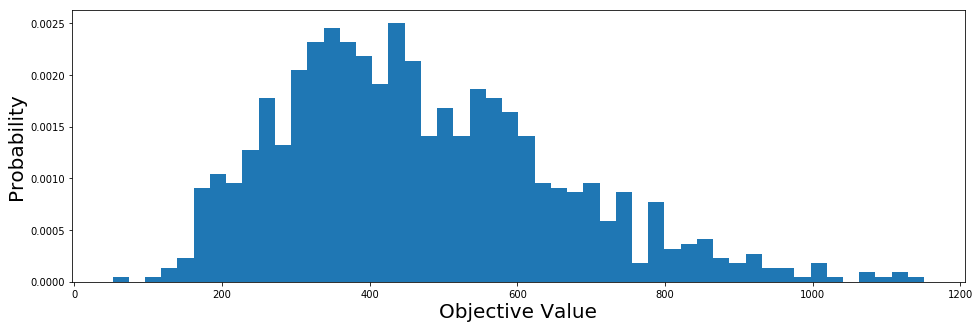

In [15]:
distribution(obj)

In [16]:
distribution2(obj)

Min: 51.7363
Max: 1151 4
Median: 442.0724
Mean: 469.0 4
95% Confidence Interval: [457.7033 481.0499]


## evaluation for SA

In [ ]:
obj = []
S = [106, 206, 156, 176, 186, 176, 176]
for _ in range(U):
        D, prob = variables_random(mu, std)
        obj_value = evaluation(S,D)
        obj.append(obj_value)

In [ ]:
distribution(obj)

In [ ]:
distribution2(obj)

# Creative - Early Stopping & Visualization

In [ ]:
def main(K, U, size_c, early_stopping=10):

    # determined variables
    N, S0, h, c, C, p, mu, std, log = variables_determined()

    # store cost for early stopping use and visualization
    cost = []
    S_list = []

     # store init value
    _, expected_h0 = get_averaged_dtc(S0, U)
    first_obj_value0 = round(np.sum(c*S0) + expected_h0, 4)
    cost.append(first_obj_value0)
    S_list.append(S0)
    print(f'Iteration   :', 0)
    print(f'Current cost:', first_obj_value0)
    print('--------------------------------------------------------')

    # initialize K
    k = 1
    # initialize order-up-to S
    S = S0

    while k <= K:
        subgradient, expected_h = get_averaged_dtc(S, U)
        # update order-up-to S
        step_wise = size_c / k
        S = S - step_wise*subgradient
        # project between lower and upper bound
        S = projection(S)
        S_list.append(S)

        # first stage optimal cost: replenishment cost and second stage cost
        first_obj_value = round(np.sum(c*S) + expected_h, 4)
        cost.append(first_obj_value)

        # log process
        if log and k % 10 == 0:
            print(f'Iteration   :', k)
            # print(f'Current second stage expected cost: ', expected_h)
            print(f'Current cost:', first_obj_value)
            # print(f'Lowest cost :', first_obj_best)
            print('--------------------------------------------------------')

        ##### early-stopping #####
        if early_stopping:
            if k > early_stopping and all(cost[-(early_stopping+1)] < cost[-early_stopping:]):
                first_obj_value = cost[-(early_stopping+1)]
                S = S_list[-(early_stopping+1)]
                break

        k += 1
    
    print(f'Final objective value: ', first_obj_value)
    print(f'Final order-up-to S:   ', np.round(S, 4))
      
    return cost, first_obj_value

In [ ]:
def plot_cost(y_value, first_obj_value):
    plt.rcParams["figure.figsize"] = (16, 5)
    x_index = y_value.index(first_obj_value)
    plt.plot([i for i in range(len(y_value))], y_value)
    plt.plot(x_index, first_obj_value, 'ro')
    plt.text(x_index - 1, first_obj_value + 10, 'Early-stopping point', c='r', size=15)
    plt.xlabel('Iteration', size=20)
    plt.ylabel('Total Cost', size=20)

In [ ]:
random.seed(420)
start_time = timer(None)
cost, first_obj_value = main(K=200, U=500, size_c=1, early_stopping=None)
timer(start_time)

In [ ]:
plot_cost(cost, first_obj_value)

In [ ]:
random.seed(420)
start_time = timer(None)
cost2, first_obj_value2 = main(K=200, U=500, size_c=1)
timer(start_time)

In [ ]:
plot_cost(cost2, first_obj_value2)

# Creative - GD with momentum

In [ ]:
def main(K, U, size_c, beta, early_stopping=10):

    # determined variables
    N, S0, h, c, C, p, mu, std, log = variables_determined()

    # store cost for early stopping use and visualization
    cost = []
    S_list = []

     # store init value
    subgradient0, expected_h0 = get_averaged_dtc(S0, U)
    first_obj_value0 = round(np.sum(c*S0) + expected_h0, 4)
    cost.append(first_obj_value0)
    S_list.append(S0)
    print(f'Iteration   :', 0)
    print(f'Current cost:', first_obj_value0)
    print('--------------------------------------------------------')

    # initialize K
    k = 1
    # initialize order-up-to S
    S = S0
    # initialize velocity
    V = subgradient0

    while k <= K:
        subgradient, expected_h = get_averaged_dtc(S, U)
        # update order-up-to S
        step_wise = size_c / k
        ##### GD with momentum #####
        V = beta * V + (1-beta) * subgradient
        S = S - step_wise*V
        # project between lower and upper bound
        S = projection(S)
        S_list.append(S)

        # first stage optimal cost: replenishment cost and second stage cost
        first_obj_value = round(np.sum(c*S) + expected_h, 4)
        cost.append(first_obj_value)

        # log process
        if log and k % 10 == 0:
            print(f'Iteration   :', k)
            # print(f'Current second stage expected cost: ', expected_h)
            print(f'Current cost:', first_obj_value)
            # print(f'Lowest cost :', first_obj_best)
            print('--------------------------------------------------------')

        # early-stopping
        if k > early_stopping and all(cost[-(early_stopping+1)] < cost[-early_stopping:]):
            first_obj_value = cost[-(early_stopping+1)]
            S = S_list[-(early_stopping+1)]
            break

        k += 1
    
    print(f'Final objective value: ', first_obj_value)
    print(f'Final order-up-to S:   ', np.round(S, 4))
      
    return cost, first_obj_value

In [ ]:
random.seed(420)
start_time = timer(None)
timer(start_time)
cost, first_obj_value = main(K=100, U=500, size_c=10, beta=0.9)
timer(start_time)

In [ ]:
plot_cost(cost, first_obj_value)
# too smooth, the result is awful

In [ ]:
random.seed(420)
start_time = timer(None)
timer(start_time)
cost, first_obj_value = main(K=200, U=500, size_c=1, beta=0.5)
timer(start_time)

In [ ]:
plot_cost(cost, first_obj_value)
# less smooth, but still not good